# For playing with YASA and sleep data in an individual file

In [1]:
%reload_ext autoreload
%autoreload 2


In [1]:
import numpy as np
import pandas as pd
import run_yasa
import logging
import mne
import yasa
import os
import argparse
import os

import mne
import numpy as np
import pandas as pd
from brainflow.board_shim import BoardShim, BoardIds
from brainflow.data_filter import DataFilter


In [2]:
log = lambda msg: logging.info(msg)


# Load MNE data

In [5]:
input_file = "C:\\dev\\play\\brainwave-data\\2024-08-26-20-56-10\\raw.fif"

In [6]:
log(f"Reading file {input_file}")
raw = mne.io.read_raw_fif(input_file, preload=True)
log(f"Finished reading file {input_file}")
input_file_without_ext = os.path.splitext(input_file)[0]


Opening raw data file C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.fif...
Isotrak not found
    Range : 0 ... 9111965 =      0.000 ... 36447.860 secs
Ready.
Reading 0 ... 9111965  =      0.000 ... 36447.860 secs...


In [18]:
from datetime import datetime, timedelta

channels = raw.info['ch_names']
sfreq = raw.info['sfreq']
start_date = raw.info['meas_date']
end_date = start_date + timedelta(seconds=float(raw.times[-1]))

display(channels)
display(sfreq)
display(start_date)
display(input_file_without_ext)
display(raw.n_times)
display(raw.times[0])
display(raw.times[-1])
display(end_date)


['F8-M1', 'Fpz-M1', 'F4-M1']

250.0

datetime.datetime(2024, 8, 26, 19, 56, 10, 722846, tzinfo=datetime.timezone.utc)

'C:\\dev\\play\\brainwave-data\\2024-08-26-20-56-10\\raw'

9111966

0.0

36447.86

datetime.datetime(2024, 8, 27, 6, 3, 38, 582846, tzinfo=datetime.timezone.utc)

## Load Brainflow data

In [ ]:
brainflow_input_file = "C:\\dev\\play\\brainwave-processor\\2024-08-18-21-33-07.brainflow.csv"
board_id = BoardIds.CYTON_BOARD.value
channels = ['F8-M1', 'Fpz-M1']

In [ ]:
log(f"Reading file {input_file}")
restored_data = DataFilter.read_file(brainflow_input_file)
log("Finished reading file")
restored_df = pd.DataFrame(np.transpose(restored_data))


In [ ]:

eeg_channels = BoardShim.get_eeg_channels(board_id)

log(f"EEG channels: {eeg_channels}")

selected_columns = [restored_df.columns[0]]
num_eeg_channels_to_select = min(len(eeg_channels), len(channels))
selected_eeg_channels = [eeg_channels[i] for i in range(num_eeg_channels_to_select)]
selected_columns.extend(selected_eeg_channels)
selected_columns.append(restored_df.columns[-2])
idx_and_eeg_channels_and_timestamp = restored_df[selected_columns]

column_names = ['sampleIdx'] + channels + ['timestamp']
idx_and_eeg_channels_and_timestamp.columns = column_names
idx_and_eeg_channels_and_timestamp['datetime'] = pd.to_datetime(idx_and_eeg_channels_and_timestamp['timestamp'],unit="s").dt.tz_localize('UTC')

eeg_channels_only = idx_and_eeg_channels_and_timestamp[channels]


# Brainflow Cyton data in uV, MNE expects V
scaled = eeg_channels_only / 1_000_000

ch_types = ['eeg'] * len(channels)

initial_timestamp = idx_and_eeg_channels_and_timestamp['datetime'].iloc[0]

sfreq = BoardShim.get_sampling_rate(board_id)
info = mne.create_info(ch_names=channels, sfreq=sfreq, ch_types=ch_types)
info.set_meas_date(initial_timestamp)
toSave = mne.io.RawArray(np.transpose(scaled), info)

Creating RawArray with float64 data, n_channels=2, n_times=8057714
    Range : 0 ... 8057713 =      0.000 ... 32230.852 secs
Ready.


C:\Users\graha\AppData\Local\Temp\ipykernel_14900\2258503004.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx_and_eeg_channels_and_timestamp['datetime'] = pd.to_datetime(idx_and_eeg_channels_and_timestamp['timestamp'],unit="s").dt.tz_localize('UTC')


In [ ]:
idx_and_eeg_channels_and_timestamp['datetime'].head()

0   2024-08-18 20:33:07.498431921+00:00
1   2024-08-18 20:33:07.498481035+00:00
2   2024-08-18 20:33:07.498507977+00:00
3   2024-08-18 20:33:07.498532057+00:00
4   2024-08-18 20:33:07.498555899+00:00
Name: datetime, dtype: datetime64[ns, UTC]

In [ ]:
restored_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.0,-12948.186749,13474.413869,-46959.584589,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,0.004,...,32.0,245.0,208.0,12.0,192.0,0.0,0.0,0.0,1.724013e+09,0.0
1,1.0,-12953.819389,13692.924523,-46873.977408,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,0.004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.724013e+09,0.0
2,2.0,-12944.588118,13916.374912,-46825.854102,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,0.004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.724013e+09,0.0
3,3.0,-12954.668755,13869.436248,-46873.306855,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,0.004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.724013e+09,0.0
4,4.0,-12949.416095,13660.223920,-46929.566196,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,0.004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.724013e+09,0.0


In [ ]:
idx_and_eeg_channels_and_timestamp.head()

,sampleIdx,F8-M1,Fpz-M1,timestamp,datetime
0,0.0,-12948.186749,13474.413869,1.724013e+09,2024-08-18 20:33:07.498431921+00:00
1,1.0,-12953.819389,13692.924523,1.724013e+09,2024-08-18 20:33:07.498481035+00:00
2,2.0,-12944.588118,13916.374912,1.724013e+09,2024-08-18 20:33:07.498507977+00:00
3,3.0,-12954.668755,13869.436248,1.724013e+09,2024-08-18 20:33:07.498532057+00:00
4,4.0,-12949.416095,13660.223920,1.724013e+09,2024-08-18 20:33:07.498555899+00:00


Opening raw data file C:\dev\play\brainwave-processor\2024-08-18-21-33-07\raw.fif...
Isotrak not found
    Range : 0 ... 8057713 =      0.000 ... 32230.852 secs
Ready.
Reading 0 ... 8057713  =      0.000 ... 32230.852 secs...


['F8-M1', 'Fpz-M1', 'F4-M1']

250.0

datetime.datetime(1970, 1, 20, 22, 53, 33, 187498, tzinfo=datetime.timezone.utc)

'C:\\dev\\play\\brainwave-processor\\2024-08-18-21-33-07\\raw'

## Load other data

## Run YASA

In [ ]:
df, json_out = run_yasa.run_yasa_report(log, input_file_without_ext, raw)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


C:\dev\play\brainwave-processor\run_yasa.py:83: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.plot_psd(average=False).savefig(input_file_without_ext + '.pre_filter_psd_plot.png', dpi=300)
C:\dev\play\brainwave-processor\run_yasa.py:83: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(average=False).savefig(input_file_without_ext + '.pre_filter_psd_plot.png', dpi=300)
C:\dev\play\brainwave-processor\venv\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 2751 samples (11.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

NOTE: plot_psd() is

C:\dev\play\brainwave-processor\run_yasa.py:86: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  filtered.plot_psd(average=False).savefig(input_file_without_ext + '.post_filter_psd_plot.png', dpi=300)
C:\dev\play\brainwave-processor\run_yasa.py:86: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  filtered.plot_psd(average=False).savefig(input_file_without_ext + '.post_filter_psd_plot.png', dpi=300)
C:\dev\play\brainwave-processor\venv\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
C:\dev\play\brainwave-processor\venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit

{'Stability': {'F8-M1': {'AnyStage': 0.875, 'Wake': 0.837, 'N1': 0.322, 'N2': 0.828, 'Deep': 0.916, 'REM': 0.88}, 'Fpz-M1': {'AnyStage': 0.883, 'Wake': 0.859, 'N1': 0.294, 'N2': 0.837, 'Deep': 0.889, 'REM': 0.921}, 'F4-M1': {'AnyStage': 0.882, 'Wake': 0.823, 'N1': 0.327, 'N2': 0.854, 'Deep': 0.867, 'REM': 0.926}, 'Aggregated': {'AnyStage': 0.894, 'Wake': 0.856, 'N1': 0.296, 'N2': 0.866, 'Deep': 0.909, 'REM': 0.908}}, 'Spindles': {'Aggregated': {'Amplitude': 45.77192812769312, 'RMS': 9.111193625985186, 'AbsPower': 1.7061467902543175, 'RelPower': 0.31929755625291467, 'Frequency': 12.933909003579066, 'Oscillations': 9.068047708725674, 'Symmetry': 0.5556077587004221}, 'F4-M1': {'Amplitude': 46.16089078888318, 'RMS': 9.910556025695692, 'AbsPower': 1.840882233408207, 'RelPower': 0.3361347442967549, 'Frequency': 12.920628327283046, 'Oscillations': 9.248587570621469, 'Symmetry': 0.5148549198874355}, 'F8-M1': {'Amplitude': 41.99495421913245, 'RMS': 7.952632003459209, 'AbsPower': 1.6255243290028

In [ ]:
df

,Stage,Confidence,Epoch,Timestamp,Source,F8-M1_Stage,F8-M1_Confidence,Fpz-M1_Stage,Fpz-M1_Confidence,F4-M1_Stage,F4-M1_Confidence,StageInt
0,W,0.999648,0,1970-01-20 23:53:33.187498+01:00,F8-M1,W,0.999648,W,0.999146,W,0.999644,0
1,W,0.999878,1,1970-01-20 23:54:03.187498+01:00,F8-M1,W,0.999878,W,0.997847,W,0.999458,0
2,W,0.999914,2,1970-01-20 23:54:33.187498+01:00,F4-M1,W,0.999866,W,0.999774,W,0.999914,0
3,W,0.999890,3,1970-01-20 23:55:03.187498+01:00,Fpz-M1,W,0.999825,W,0.999890,W,0.999874,0
4,W,0.999823,4,1970-01-20 23:55:33.187498+01:00,Fpz-M1,W,0.999770,W,0.999823,W,0.999415,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1069,W,0.888333,1069,1970-01-21 08:48:03.187498+01:00,Fpz-M1,W,0.631320,W,0.888333,W,0.761468,0
1070,W,0.879404,1070,1970-01-21 08:48:33.187498+01:00,Fpz-M1,W,0.814413,W,0.879404,W,0.736621,0
1071,W,0.962852,1071,1970-01-21 08:49:03.187498+01:00,Fpz-M1,W,0.723112,W,0.962852,W,0.791457,0
1072,W,0.970005,1072,1970-01-21 08:49:33.187498+01:00,Fpz-M1,W,0.922054,W,0.970005,W,0.652743,0


In [ ]:
json_out

{'Stability': {'F8-M1': {'AnyStage': 0.875,
   'Wake': 0.837,
   'N1': 0.322,
   'N2': 0.828,
   'Deep': 0.916,
   'REM': 0.88},
  'Fpz-M1': {'AnyStage': 0.883,
   'Wake': 0.859,
   'N1': 0.294,
   'N2': 0.837,
   'Deep': 0.889,
   'REM': 0.921},
  'F4-M1': {'AnyStage': 0.882,
   'Wake': 0.823,
   'N1': 0.327,
   'N2': 0.854,
   'Deep': 0.867,
   'REM': 0.926},
  'Aggregated': {'AnyStage': 0.894,
   'Wake': 0.856,
   'N1': 0.296,
   'N2': 0.866,
   'Deep': 0.909,
   'REM': 0.908}},
 'Spindles': {'Aggregated': {'Amplitude': 45.77192812769312,
   'RMS': 9.111193625985186,
   'AbsPower': 1.7061467902543175,
   'RelPower': 0.31929755625291467,
   'Frequency': 12.933909003579066,
   'Oscillations': 9.068047708725674,
   'Symmetry': 0.5556077587004221},
  'F4-M1': {'Amplitude': 46.16089078888318,
   'RMS': 9.910556025695692,
   'AbsPower': 1.840882233408207,
   'RelPower': 0.3361347442967549,
   'Frequency': 12.920628327283046,
   'Oscillations': 9.248587570621469,
   'Symmetry': 0.514854919

## How much value are the other channels adding

In [ ]:
import yasa_helpers

In [ ]:
print(yasa_helpers.channel_comparison(df, channels))


{'F8-M1-Fpz-M1-F4-M1': 'Number of stages: 1074\nStages where F8-M1 and Fpz-M1 do not agree: 146 13.59%\nOf those stages of non-agreement:\nF8-M1 5% more confident than Fpz-M1: 48 rows 4.47%\n  Of these, 26 rows agree with F4-M1 2.42%\nF8-M1 10% more confident than Fpz-M1: 33 rows 3.07%\n  Of these, 23 rows agree with F4-M1 2.14%\nF8-M1 20% more confident than Fpz-M1: 15 rows 1.40%\n  Of these, 12 rows agree with F4-M1 1.12%\nStages where F8-M1 and F4-M1 agree and disagree with Fpz-M1: 51 rows 4.75%\n  Whether either F8-M1 or F4-M1 5% more confident than Fpz-M1: 30 rows 2.79%\n  Whether either F8-M1 or F4-M1 10% more confident than Fpz-M1: 26 rows 2.42%\n  Whether either F8-M1 or F4-M1 20% more confident than Fpz-M1: 15 rows 1.40%\nStages where F8-M1 and F4-M1 agree and agree with Fpz-M1: 882 rows 82.12%', 'F8-M1-F4-M1-Fpz-M1': 'Number of stages: 1074\nStages where F8-M1 and F4-M1 do not agree: 141 13.13%\nOf those stages of non-agreement:\nF8-M1 5% more confident than F4-M1: 41 rows 3.

## Probability of changing from one stage to another

In [ ]:
# 0 = "W", 1 = "N1", 2 = "N2", 3 = "N3", 4 = "REM"
counts, probs = yasa.transition_matrix(df['StageInt'])
print(probs.round(3))

sleep_stability_any_stage = np.diag(probs.loc[2:, 2:]).mean().round(3)
sleep_stability_wake = probs.loc[0, 0].round(3)
sleep_stability_n1 = probs.loc[1, 1].round(3)
sleep_stability_n2 = probs.loc[2, 2].round(3)
sleep_stability_deep = probs.loc[3, 3].round(3)
sleep_stability_rem = probs.loc[4, 4].round(3)
print (f"Chance of staying in the same stage on any given epoch = {sleep_stability_any_stage}")
print (f"Chance of staying in wake           on any given epoch = {sleep_stability_wake}")
print (f"Chance of staying in N1 sleep       on any given epoch = {sleep_stability_n1}")
print (f"Chance of staying in N2 sleep       on any given epoch = {sleep_stability_n2}")
print (f"Chance of staying in deep sleep     on any given epoch = {sleep_stability_deep}")


To Stage        0      1      2      3      4
From Stage                                   
0           0.856  0.095  0.020  0.005  0.025
1           0.130  0.296  0.463  0.000  0.111
2           0.035  0.035  0.866  0.035  0.030
3           0.006  0.000  0.085  0.909  0.000
4           0.028  0.020  0.044  0.000  0.908
Chance of staying in the same stage on any given epoch = 0.894
Chance of staying in wake           on any given epoch = 0.856
Chance of staying in N1 sleep       on any given epoch = 0.296
Chance of staying in N2 sleep       on any given epoch = 0.866
Chance of staying in deep sleep     on any given epoch = 0.909


In [ ]:
ss = yasa_helpers.sleep_stability(df['StageInt'])
ss

{'AnyStage': 0.894,
 'Wake': 0.856,
 'N1': 0.296,
 'N2': 0.866,
 'Deep': 0.909,
 'REM': 0.908}

## Spindle investigation

In [ ]:
filtered = run_yasa.get_filtered_and_scaled_data(raw)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 2751 samples (11.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



In [ ]:
sp = yasa.spindles_detect(filtered, sfreq)


In [ ]:
sp.summary()

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,20.868,21.440,21.512,0.644,44.179288,8.522891,1.786185,0.312781,13.429184,8.0,0.882716,F8-M1,0
1,3377.280,3377.536,3378.000,0.720,54.951888,9.062417,1.661560,0.335658,12.995033,9.0,0.353591,F8-M1,0
2,3540.560,3541.112,3541.252,0.692,43.749677,9.606439,1.876675,0.335431,12.512334,8.0,0.793103,F8-M1,0
3,3589.792,3590.316,3590.504,0.712,44.118203,8.304437,1.687262,0.241835,13.397101,9.0,0.731844,F8-M1,0
4,3649.452,3649.752,3649.976,0.524,38.477853,8.360699,1.885057,0.410345,12.686107,7.0,0.568182,F8-M1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,31012.196,31012.960,31013.152,0.956,71.287718,14.364883,2.057752,0.259753,12.712272,12.0,0.795833,F4-M1,2
271,31026.012,31026.452,31026.652,0.640,48.825754,9.612551,1.949254,0.438554,12.430706,8.0,0.683230,F4-M1,2
272,31203.404,31203.736,31203.912,0.508,128.287640,28.884658,2.741596,0.219151,13.609761,6.0,0.648438,F4-M1,2
273,31329.188,31329.292,31330.224,1.036,38.375108,5.747104,1.436992,0.325000,13.567681,14.0,0.100000,F4-M1,2


In [ ]:
len(sp.summary())

275

In [ ]:
sp.summary(grp_chan=True, aggfunc='mean')


,Count,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry
Channel,,,,,,,,,
F4-M1,177,0.748746,46.160891,9.910556,1.840882,0.336135,12.920628,9.248588,0.514855
F8-M1,63,0.752571,41.994954,7.952632,1.625524,0.313205,12.809181,9.126984,0.586588
Fpz-M1,35,0.737600,49.159939,9.470393,1.652034,0.308553,13.071917,8.828571,0.565380


<Figure size 640x480 with 0 Axes>

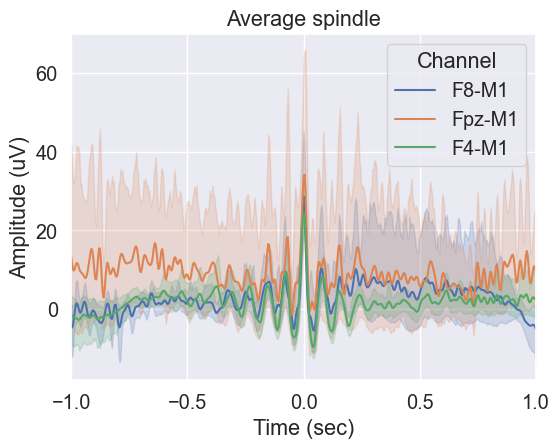

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.clf()
axes = sp.plot_average(center='Peak', time_before=1, time_after=1)


In [ ]:
axes.get_figure().savefig(input_file_without_ext + f'.average_spindle.png', dpi=300)

In [ ]:
# How well do the channels agree?
sp.compare_channels(score="recall", max_distance_sec=0.5).round(3)

# (So on row 0, column 1, 0.63 would mean 63% of spindles on C0 were also found by C1)


Channel,F8-M1,Fpz-M1,F4-M1
Channel,,,
F8-M1,1.000,0.270,0.714
Fpz-M1,0.486,1.000,0.600
F4-M1,0.254,0.119,1.000


In [ ]:
# F1-score is very similar view of the same data
sp.compare_channels(max_distance_sec=0.5).round(3)


Channel,F8-M1,Fpz-M1,F4-M1
Channel,,,
F8-M1,1.000,0.347,0.375
Fpz-M1,0.347,1.000,0.198
F4-M1,0.375,0.198,1.000


In [ ]:
sp_multi = yasa.spindles_detect(filtered, sfreq, ch_names=channels, multi_only=True, remove_outliers=True)
all_spindles = sp_multi.summary()
print(all_spindles.shape[0], 'spindles detected that are common to at least two electrodes.')
all_spindles.head().round(3)


111 spindles detected that are common to at least two electrodes.


,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,20.868,21.440,21.512,0.644,44.179,8.523,1.786,0.313,13.429,8.0,0.883,F8-M1,0
1,3377.280,3377.536,3378.000,0.720,54.952,9.062,1.662,0.336,12.995,9.0,0.354,F8-M1,0
2,3540.560,3541.112,3541.252,0.692,43.750,9.606,1.877,0.335,12.512,8.0,0.793,F8-M1,0
3,3649.452,3649.752,3649.976,0.524,38.478,8.361,1.885,0.410,12.686,7.0,0.568,F8-M1,0
4,8041.652,8042.096,8042.260,0.608,55.348,10.753,1.971,0.326,12.220,7.0,0.725,F8-M1,0


In [ ]:
sp_multi.summary(grp_chan=True)


,Count,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry
Channel,,,,,,,,,
F4-M1,47,0.773191,41.713164,8.858387,1.809971,0.345488,12.745438,9.574468,0.546904
F8-M1,43,0.711442,36.344822,7.184102,1.607110,0.310589,12.802567,8.604651,0.607054
Fpz-M1,21,0.742286,32.772103,6.600920,1.549899,0.331183,12.995819,9.000000,0.568469


In [ ]:
coincidence = sp.get_coincidence_matrix()
coincidence


Channel,F8-M1,Fpz-M1,F4-M1
Channel,,,
F8-M1,1.000000,0.000041,0.000019
Fpz-M1,0.000041,1.000000,0.000016
F4-M1,0.000019,0.000016,1.000000


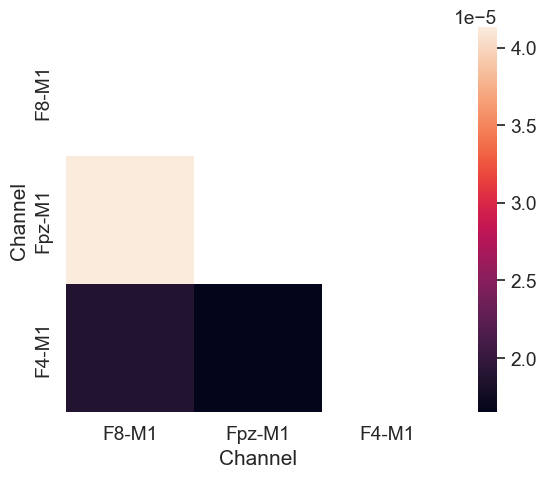

In [ ]:
import seaborn as sns
sns.set(style="white", font_scale=1.25)

mask = np.zeros_like(coincidence)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(7, 5))
ax = sns.heatmap(coincidence, mask=mask, square=True, cmap="rocket")


Conclusions:

2024-07-28: 
- Each channel (F8, T4, O2) catching a bunch of spindles the others missed.
- F8 weakest.  O2 catches 3x as many as F8.  T4 2x F8.


In [ ]:
out = yasa_helpers.spindles(filtered)

In [ ]:
out

{'Aggregated': {'Amplitude': 45.77192812769312,
  'RMS': 9.111193625985186,
  'AbsPower': 1.7061467902543175,
  'RelPower': 0.31929755625291467,
  'Frequency': 12.933909003579066,
  'Oscillations': 9.068047708725674,
  'Symmetry': 0.5556077587004221},
 'F4-M1': {'Amplitude': 46.16089078888318,
  'RMS': 9.910556025695692,
  'AbsPower': 1.840882233408207,
  'RelPower': 0.3361347442967549,
  'Frequency': 12.920628327283046,
  'Oscillations': 9.248587570621469,
  'Symmetry': 0.5148549198874355},
 'F8-M1': {'Amplitude': 41.99495421913245,
  'RMS': 7.952632003459209,
  'AbsPower': 1.625524329002897,
  'RelPower': 0.3132047802776167,
  'Frequency': 12.809181298768294,
  'Oscillations': 9.126984126984127,
  'Symmetry': 0.5865884083503556},
 'Fpz-M1': {'Amplitude': 49.15993937506375,
  'RMS': 9.470392848800651,
  'AbsPower': 1.652033808351849,
  'RelPower': 0.3085531441843724,
  'Frequency': 13.071917384685854,
  'Oscillations': 8.82857142857143,
  'Symmetry': 0.5653799478634752}}

## Slow waves

In [ ]:
import mne
import yasa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skewnorm
from scipy.linalg import eigh
from scipy.interpolate import RectBivariateSpline
from scipy.signal import find_peaks, welch, detrend
sns.set(context='notebook', font_scale=1.3)
sf = sfreq
from yasa import sw_detect



In [ ]:
sw = sw_detect(filtered, sf)


In [ ]:
summary = sw.summary()
# Fields all covered https://github.com/raphaelvallat/yasa/blob/master/notebooks/05_sw_detection.ipynb
summary

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Channel,IdxChannel
0,28.092,28.504,28.736,28.956,29.160,1.068,-45.718268,49.194944,94.913211,409.108669,0.936330,F8-M1,0
1,29.160,29.400,29.704,29.940,30.392,1.232,-59.146246,18.603997,77.750242,255.757376,0.811688,F8-M1,0
2,36.556,36.940,37.252,37.384,37.532,0.976,-64.184227,14.893486,79.077713,253.454208,1.024590,F8-M1,0
3,68.984,69.264,69.532,69.788,70.212,1.228,-43.865761,32.297267,76.163027,284.190401,0.814332,F8-M1,0
4,71.176,71.420,71.744,72.272,72.540,1.364,-41.991057,33.426686,75.417743,232.770811,0.733138,F8-M1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3651,31408.596,31408.792,31409.044,31409.160,31409.272,0.676,-104.529895,24.476410,129.006305,511.929782,1.479290,F4-M1,2
3652,31507.000,31507.264,31507.520,31507.696,31507.892,0.892,-72.310703,37.067300,109.378003,427.257824,1.121076,F4-M1,2
3653,31508.988,31509.292,31509.668,31510.156,31510.612,1.624,-82.774017,104.135846,186.909863,497.100700,0.615764,F4-M1,2
3654,31521.076,31521.456,31521.740,31521.992,31522.736,1.660,-43.116271,38.599661,81.715933,287.732158,0.602410,F4-M1,2


In [ ]:
sw.summary(grp_chan=True, aggfunc='mean')

,Count,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency
Channel,,,,,,,
F4-M1,1163,1.317909,-60.673059,57.796769,118.469828,415.237872,0.812946
F8-M1,861,1.378337,-60.113219,50.588559,110.701778,358.527996,0.773852
Fpz-M1,1632,1.280221,-63.352732,56.059815,119.412547,422.817528,0.839503


In [ ]:
ValPosPeakMean = summary["ValPosPeak"].mean()
ValPosPeakStdDev = summary["ValPosPeak"].std()
ValNegPeakMean = summary["ValNegPeak"].mean()
ValNegPeakStdDev = summary["ValNegPeak"].std()
DurationMean = summary["Duration"].mean()
DurationStdDev = summary["Duration"].std()

print(f"ValPosPeakMean: {ValPosPeakMean} (stddev = {ValPosPeakStdDev})")
print(f"ValNegPeakMean: {ValNegPeakMean} (stddev = {ValNegPeakStdDev})")
print(f"DurationMean: {DurationMean} (stddev = {DurationStdDev})")


ValPosPeakMean: 55.323854119437286 (stddev = 27.580841666496145)
ValNegPeakMean: -61.73739247400275 (stddev = 20.23704149868295)
DurationMean: 1.315316192560175 (stddev = 0.3473106253001016)


In [ ]:
len(sw.summary())

3656

In [ ]:
sw.summary(grp_chan=True, aggfunc='mean')


,Count,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency
Channel,,,,,,,
F4-M1,1163,1.317909,-60.673059,57.796769,118.469828,415.237872,0.812946
F8-M1,861,1.378337,-60.113219,50.588559,110.701778,358.527996,0.773852
Fpz-M1,1632,1.280221,-63.352732,56.059815,119.412547,422.817528,0.839503


<Figure size 640x480 with 0 Axes>

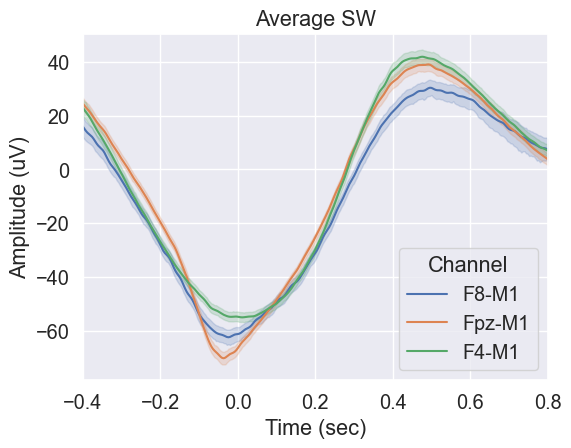

In [ ]:
plt.clf()
sw.plot_average(time_before=0.4, time_after=0.8, center="NegPeak");


In [ ]:
import yasa_helpers
out, summary = yasa_helpers.slow_waves(filtered)

ValueError: too many values to unpack (expected 2)

In [ ]:
out

# Sleep stats

In [ ]:
ss = yasa.sleep_statistics(df['StageInt'], sf_hyp=1/30)

In [ ]:
ss

{'TIB': 537.0,
 'SPT': 465.0,
 'WASO': 29.0,
 'TST': 436.0,
 'N1': 27.0,
 'N2': 201.5,
 'N3': 82.0,
 'REM': 125.5,
 'NREM': 310.5,
 'SOL': 54.5,
 'Lat_N1': 54.5,
 'Lat_N2': 56.0,
 'Lat_N3': 67.0,
 'Lat_REM': 134.5,
 '%N1': 6.192660550458716,
 '%N2': 46.21559633027523,
 '%N3': 18.807339449541285,
 '%REM': 28.78440366972477,
 '%NREM': 71.21559633027523,
 'SE': 81.19180633147114,
 'SME': 93.76344086021506}